In [1]:
import csv
import numpy as np
import pandas as pd
import logging
import word2vecReaderUtils as utils
from numpy import exp, dot, zeros, outer, random, dtype, float32 as REAL,\
    uint32, seterr, array, uint8, vstack, argsort, fromstring, sqrt, newaxis,\
    ndarray, empty, sum as np_sum, prod
from six import string_types
from gensim import matutils
import load_word2vec as NN
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

#load model
model_path = "./word2vec_twitter_model.bin"
print("Loading the model, this can take some time...")
model = NN.Word2Vec.load_word2vec_format(model_path, binary=True)
print("The vocabulary size is: "+str(len(model.vocab)))

Loading the model, this can take some time...
The vocabulary size is: 3039345


In [2]:
train_data = []
with open("small_2train.csv","r", encoding='utf-8', errors='ignore') as f:
    reader = csv.reader(f)
    for row in reader:
        train_data.append(row)
train_text_x = []
train_text_y = []
for each in train_data:
    train_text_x.append(each[5])
    train_text_y.append(each[0])

#combine files together
total = train_text_x

def preprocessing(total=total):
    processed_docs = []
    total_voc = []
    stemmer = nltk.stem.PorterStemmer()
    for raw in total:
        normal_doc = []
        temp = word_tokenize(raw)
        for each in range(len(temp)):
            if(not temp[each].isalpha()):
                continue
            stem_word = temp[each].lower()
            if(stem_word in stopwords.words('english')):
                continue
            if(stem_word=='' or stem_word=='“'or stem_word=='”' or stem_word=='’' or stem_word=='…' or ('http' in stem_word) or stem_word=='rt'):
                continue
            normal_doc.append(stem_word)
            total_voc.append(stem_word)
        normal_doc = list(filter(None, normal_doc))
        processed_docs.append(normal_doc)
    return processed_docs,total_voc

processed_docs, total_vec = preprocessing()

In [3]:
def convert_docs_index(processed_docs):
    for sent in processed_docs:
        for inde in range(len(sent)):
            try:
                sent[inde] = model.vocab[sent[inde]].index
            except:
                sent[inde] = 0
    return processed_docs

processed_docs = convert_docs_index(processed_docs)

In [2]:
from tensorflow.python import keras
from tensorflow.python.keras.utils import np_utils
import matplotlib.pyplot as plt

In [15]:
#曲线图类
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
#         self.val_loss = {'batch':[], 'epoch':[]}
#         self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
#         self.val_loss['batch'].append(logs.get('val_loss'))
#         self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
#         self.val_loss['epoch'].append(logs.get('val_loss'))
#         self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
#         if loss_type == 'epoch':
#             # val_acc
#             plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
#             # val_loss
#             plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [8]:
# corpus_length = [ len(corpus) for corpus in processed_docs ]
# corpus_length = np.array(corpus_length)
# max_length = int(np.mean(corpus_length) + 2*np.std(corpus_length))

embedding_dim = 400
num_words = 200000
embedding_matrix = np.zeros((num_words, embedding_dim))
for i in range(num_words):
    embedding_matrix[i,:] = model.syn0[i]
embedding_matrix = embedding_matrix.astype('float32')

In [5]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras.layers.normalization import BatchNormalization

In [8]:
train_pad = pad_sequences(processed_docs, maxlen=max_length,
                            padding='pre', truncating='pre')
train_pad[ train_pad>=num_words ] = 0
train_target = np.concatenate( (np.zeros(500), np.ones(500)) )

#split trainign file into two part(2:8), test and training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.3,
                                                    random_state=12)

In [9]:
#create model
cn_model = Sequential()
# first layer as embedding layer
cn_model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=20,
                    trainable=False))
# second layer we create bi-LSTM layer
cn_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
cn_model.add(Dropout(0.2))
cn_model.add(LSTM(units=128, return_sequences=False))
cn_model.add(Dropout(0.2))
# cn_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True))
# activation function we choose relue
cn_model.add(Dense(64, activation='relu'))
cn_model.add(Dropout(0.2))
cn_model.add(Dense(1, activation='sigmoid'))
cn_model.summary()
# learning rate we use 0.001

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 400)           80000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 512)           1345536   
_________________________________________________________________
dropout (Dropout)            (None, 20, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)        

In [10]:
optimizer = Adam(lr=1e-3)

cn_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
# we create a check point, which we could use for further purpose
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)
# tring to load existing data
try:
    cn_model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

# we define back-probagation function
# earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# lr_reduction = ReduceLROnPlateau(monitor='val_loss',
#                                        factor=0.1, min_lr=1e-5, patience=0,
#                                        verbose=1)

In [16]:
#load our function into model
# callbacks = [
#     earlystopping,
#     checkpoint,
#     lr_reduction
# ]
#start training our model
history = LossHistory()
cn_model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=5,
          batch_size=128,
          callbacks=[history])

print("=================================================================================================================")
print('Start testing prediction')
result = cn_model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

Train on 630 samples, validate on 70 samples
Epoch 1/5
630/630 [==============================] - 2s 3ms/sample - loss: 0.1999 - acc: 0.9175 - val_loss: 0.4970 - val_acc: 0.7714
Epoch 2/5
630/630 [==============================] - 2s 4ms/sample - loss: 0.1565 - acc: 0.9349 - val_loss: 0.5155 - val_acc: 0.7714
Epoch 3/5
630/630 [==============================] - 2s 4ms/sample - loss: 0.1191 - acc: 0.9524 - val_loss: 0.5484 - val_acc: 0.8143
Epoch 4/5
630/630 [==============================] - 2s 4ms/sample - loss: 0.0888 - acc: 0.9635 - val_loss: 0.5872 - val_acc: 0.8000
Epoch 5/5
630/630 [==============================] - 2s 4ms/sample - loss: 0.0697 - acc: 0.9714 - val_loss: 0.6364 - val_acc: 0.7857
Start testing prediction
300/300 [==============================] - 0s 1ms/sample - loss: 0.6964 - acc: 0.8300
Accuracy:83.00%


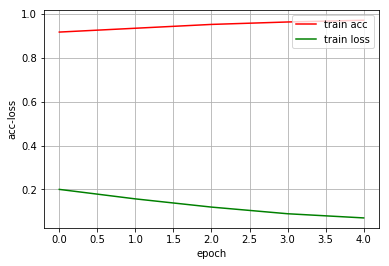

In [17]:
history.loss_plot('epoch')

In [25]:
def predict_sentiment(text):
#     print(text)
    #tokenize
    temp = word_tokenize(text)
#     print(temp)
    simple = []
    for each in range(len(temp)):
        if(not temp[each].isalpha()):
            continue
        stem_word = temp[each].lower()
        if(stem_word=='' or stem_word=='“'or stem_word=='”' or stem_word=='’' or stem_word=='…'):
            continue
        try:
            simple.append(model.vocab[stem_word].index)
        except:
            simple.append(0)
    # padding
#     print(simple)
    tokens_pad = pad_sequences([simple], maxlen=20,
                           padding='pre', truncating='pre')
    tokens_pad[tokens_pad>=20000] = 0
    # 预测
    result = cn_model.predict(x=tokens_pad)
    print(text)
    coef = result[0][0]
    if coef > 0.5:
        print('*Positive comment','output=%.5f'%coef)
#     elif(coef < 0.65 and coef > 0.45):
#         print("Nuetural comment",' ouput=%.5f'%coef)
    else:
        print('*Negative comment','output=%.5f'%coef)

In [36]:
text_list = [
    """RT @dbongino: Is Hillary serious with these 
    absurd comments? There’s not a more charmed family in 
    the history of politics than the Clintons…""",
    "But maybe he is just kidding... Or?",
    "Donald Trump met with Twitter CEO Jack Dorsey in the Oval Office, hours after blasting the social media company for playing…,",
    "he is a stupid person",
    "what the fuck",
    "I love trump",
    "no one can be better than him",
    "The Guardian view on Donald Trump’s UK visit: a mistake | Editorial https://t.co/GXO2OGXUX2,",
    "RT @JazNicole3: 1. It’s YG song 2. It’s still FUCK DONALD TRUMP 3. Fuck this HOE too https://t.co/D2v8Rpcwr9",
    "I've signed the petition to stop Donald Trump speaking at the UK Parliament ?€? you should too. #DumpTrump",
    "How can he mock anyone",
    "Honestly from someone who knows ????????",
    "he should call it stop",
    "It's making a mockery of Democrats!"
]
for text in text_list:
    predict_sentiment(text)
    print("================================================================================================")

RT @dbongino: Is Hillary serious with these 
    absurd comments? There’s not a more charmed family in 
    the history of politics than the Clintons…
*Negative comment output=0.37617
But maybe he is just kidding... Or?
*Positive comment output=0.60223
Donald Trump met with Twitter CEO Jack Dorsey in the Oval Office, hours after blasting the social media company for playing…,
*Positive comment output=0.72906
he is a stupid person
*Negative comment output=0.23921
what the fuck
*Negative comment output=0.38889
I love trump
*Positive comment output=0.84922
no one can be better than him
*Positive comment output=0.61734
The Guardian view on Donald Trump’s UK visit: a mistake | Editorial https://t.co/GXO2OGXUX2,
*Negative comment output=0.30265
RT @JazNicole3: 1. It’s YG song 2. It’s still FUCK DONALD TRUMP 3. Fuck this HOE too https://t.co/D2v8Rpcwr9
*Positive comment output=0.58827
I've signed the petition to stop Donald Trump speaking at the UK Parliament ?€? you should too. #DumpTrump
*P